In [11]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
#import ipywidgets as ipyw
#from ipywidgets import interact
import seaborn as sns
#import nbconvert
import graphviz
#import scipy as sp

import numpy as np
np.random.seed(seed=100)
random_seed = 100


import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
import sys
sys.tracebacklimit = 0 # turn off the error tracebacks

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Predictor Variable Data Collection

In [12]:
url = 'https://fbref.com/en/comps/Big5/2022-2023/keepersadv/players/2022-2023-Big-5-European-Leagues-Stats'
html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
df = pd.read_html(html_content)
df[1].columns = df[1].columns.droplevel(0) # drop top header row
#df[1] = df[1][df[1]['Rk'].ne('Rk')].reset_index()

men_adv_stats = df[1]

In [13]:
url = 'https://fbref.com/en/comps/Big5/2022-2023/keepers/players/2022-2023-Big-5-European-Leagues-Stats'
html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
df = pd.read_html(html_content)
df[1].columns = df[1].columns.droplevel(0) # drop top header row
#df[1] = df[1][df[1]['Rk'].ne('Rk')].reset_index()

men_reg_stats = df[1]

## Data Cleaning

In [14]:
adv_cols = men_adv_stats.columns
adv_cols

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'GA', 'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG/SoT', 'PSxG+/-', '/90',
       'Cmp', 'Att', 'Cmp%', 'Att (GK)', 'Thr', 'Launch%', 'AvgLen', 'Att',
       'Launch%', 'AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90', 'AvgDist',
       'Matches'],
      dtype='object')

In [15]:
adv_cols = ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'GA', 'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG/SoT', 'PSxG+/-', '/90',
       'Cmp', 'Att', 'Cmp%', 'Att (GK)', 'Thr', 'Launch%_Passes', 'AvgLen_Passes', 'Att_GK',
       'Launch%_GK', 'AvgLen_GK', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90', 'AvgDist',
       'Matches']

In [16]:
men_adv_stats.columns = adv_cols

In [17]:
adv_cols = ['Player',
       'GA', 'PKA', 'FK', 'CK', 'OG', 'PSxG+/-', '/90',
       'Cmp%',  'Thr', 'Launch%_Passes','AvgLen_GK', 'Opp', 'Stp%', '#OPA/90', 'AvgDist']

#Cmp% - Passes completed for launched
#Thr - number of throws attempted
#Launch% - % passes that are launched
#AvgLen - Average goal kick length

In [18]:
men_adv_stats = men_adv_stats.loc[:, adv_cols]
men_adv_stats = men_adv_stats.loc[:,~men_adv_stats.columns.duplicated()].copy()
#need to remove duplicates of title rows 
men_adv_stats.T

0                   1              2        3    \
Player          Álvaro Aceves  Julen Agirrezabala  Doğan Alemdar  Alisson   
GA                          0                   6              8       43   
PKA                         0                   0              1        2   
FK                          0                   0              0        0   
CK                          0                   0              2        0   
OG                          0                   0              0        2   
PSxG+/-                  +0.1                -0.5           -1.5    +10.1   
/90                     +0.90               -0.06          -0.32    +0.27   
Cmp%                     50.0                36.6           34.3     41.0   
Thr                         3                  33             14      210   
Launch%_Passes           28.6                29.6           38.5     18.4   
AvgLen_GK                24.0                55.4           51.4     31.3   
Opp                         1                  96             75      397   
Stp%                      0.0                11.5            6.7      5.8   
#OPA/90                 13.85                1.33           1.11     2.41   
AvgDist                  33.0                15.4           14.8     19.8   

                            4                  5              6    \
Player          Alphonse Areola  Kepa Arrizabalaga  Sergio Asenjo   
GA                            7                 33             21   
PKA                           2                  1              1   
FK                            0                  1              1   
CK                            1                  4              0   
OG                            0                  3              0   
PSxG+/-                    +0.3               +5.0           -4.2   
/90                       +0.09              +0.18          -0.42   
Cmp%                       37.8               31.9           35.8   
Thr                          14                151             46   
Launch%_Passes             39.3               17.1           38.8   
AvgLen_GK                  33.0               31.5           51.2   
Opp                          47                332            166   
Stp%                        4.3                4.5            3.0   
#OPA/90                    0.29               1.82           1.70   
AvgDist                    10.3               16.9           16.1   

                        7            8                9    ...  \
Player          Emil Audero  Édgar Badía  Francesco Bardi  ...   
GA                       39           63                0  ...   
PKA                       5            7                0  ...   
FK                        0            0                0  ...   
CK                        4            4                0  ...   
OG                        2            2                0  ...   
PSxG+/-                -4.7         +8.5             +0.6  ...   
/90                   -0.19        +0.24            +0.56  ...   
Cmp%                   36.1         45.3             55.6  ...   
Thr                     104          166                5  ...   
Launch%_Passes         45.8         33.8             38.5  ...   
AvgLen_GK              44.2         41.7             33.4  ...   
Opp                     356          574               10  ...   
Stp%                    6.7          3.7              0.0  ...   
#OPA/90                0.92         0.56             0.00  ...   
AvgDist                13.9         12.7              NaN  ...   

                              206      207          208         209  \
Player          Guglielmo Vicario   Player  Iván Villar  Danny Ward   
GA                             39       GA           24          46   
PKA                             4      PKA            3           2   
FK                              0       FK            0           2   
CK                              8       CK            6         

In [19]:
men_adv_stats = men_adv_stats[men_adv_stats.Player != "Player"]

In [20]:
reg_cols = men_reg_stats.columns
reg_cols

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min', '90s', 'GA', 'GA90', 'SoTA', 'Saves', 'Save%', 'W',
       'D', 'L', 'CS', 'CS%', 'PKatt', 'PKA', 'PKsv', 'PKm', 'Save%',
       'Matches'],
      dtype='object')

In [21]:
reg_cols = ['Player', 'Min', 'GA90', 'SoTA', 'Saves', 'Save%']

In [22]:
men_reg_stats = men_reg_stats.loc[:, reg_cols]
men_reg_stats = men_reg_stats.loc[:,~men_reg_stats.columns.duplicated()].copy()
#men_reg_stats.T

In [23]:
df = pd.merge(men_adv_stats, men_reg_stats, on='Player', how = 'inner')
df.T.head(22)

0                   1              2        3    \
Player          Álvaro Aceves  Julen Agirrezabala  Doğan Alemdar  Alisson   
GA                          0                   6              8       43   
PKA                         0                   0              1        2   
FK                          0                   0              0        0   
CK                          0                   0              2        0   
OG                          0                   0              0        2   
PSxG+/-                  +0.1                -0.5           -1.5    +10.1   
/90                     +0.90               -0.06          -0.32    +0.27   
Cmp%                     50.0                36.6           34.3     41.0   
Thr                         3                  33             14      210   
Launch%_Passes           28.6                29.6           38.5     18.4   
AvgLen_GK                24.0                55.4           51.4     31.3   
Opp                         1                  96             75      397   
Stp%                      0.0                11.5            6.7      5.8   
#OPA/90                 13.85                1.33           1.11     2.41   
AvgDist                  33.0                15.4           14.8     19.8   
Min                        13                 675            406     3330   
GA90                     0.00                0.80           1.77     1.16   
SoTA                        3                  19             16      147   
Saves                       3                  13              7      105   
Save%                   100.0                68.4           56.3     72.1   

                            4                  5              6    \
Player          Alphonse Areola  Kepa Arrizabalaga  Sergio Asenjo   
GA                            7                 33             21   
PKA                           2                  1              1   
FK                            0                  1              1   
CK                            1                  4              0   
OG                            0                  3              0   
PSxG+/-                    +0.3               +5.0           -4.2   
/90                       +0.09              +0.18          -0.42   
Cmp%                       37.8               31.9           35.8   
Thr                          14                151             46   
Launch%_Passes             39.3               17.1           38.8   
AvgLen_GK                  33.0               31.5           51.2   
Opp                          47                332            166   
Stp%                        4.3                4.5            3.0   
#OPA/90                    0.29               1.82           1.70   
AvgDist                    10.3               16.9           16.1   
Min                         309               2565            900   
GA90                       2.04               1.16           2.10   
SoTA                         16                120             51   
Saves                         9                 90             30   
Save%                      68.8               73.3           60.8   

                        7            8                9    ...           210  \
Player          Emil Audero  Édgar Badía  Francesco Bardi  ...  Sven Ulreich   
GA                       39           63                0  ...             2   
PKA                       5            7                0  ...             0   
FK                        0            0                0  ...             0   
CK                        4            4                0  ...             1   
OG                        2            2                0  ...             0   
PSxG+/-                -4.7         +8.5             +0.6  ...          +0.4   
/90                   -0.19        +0.24            +0.56  ...         +0.13   
Cmp%                   36.1         45.3             55.6  ...          34.6   
Thr         

In [24]:
df = df.drop_duplicates(subset=['Player'], keep="first")

In [25]:
df.describe()

Player   GA  PKA   FK   CK   OG PSxG+/-    /90  Cmp%  Thr  ...  \
count             202  201  201  201  201  201     201    201   199  202  ...   
unique            202   63   11    5   12    5     100     98   138  124  ...   
top     Álvaro Aceves    2    0    0    0    0     0.0  +0.01  33.3    3  ...   
freq                1   14   59  140   51  107       7      8     8    7  ...   

       AvgLen_GK  Opp Stp% #OPA/90 AvgDist  Min  GA90 SoTA Saves  Save%  
count        201  201  200     201     196  202   201  201   201    198  
unique       161  160   87     105     100  107   113  118    98    119  
top         42.9    1  0.0    0.00    15.4   90  1.00    4     4  100.0  
freq           4    4   20      23       7   19    13   11    11      9  

[4 rows x 21 columns]

In [26]:
cols = df.columns

for col in cols:
    if col != "Player":
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, 0 to 219
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player          202 non-null    object 
 1   GA              201 non-null    float64
 2   PKA             201 non-null    float64
 3   FK              201 non-null    float64
 4   CK              201 non-null    float64
 5   OG              201 non-null    float64
 6   PSxG+/-         201 non-null    float64
 7   /90             201 non-null    float64
 8   Cmp%            199 non-null    float64
 9   Thr             202 non-null    int64  
 10  Launch%_Passes  201 non-null    float64
 11  AvgLen_GK       201 non-null    float64
 12  Opp             201 non-null    float64
 13  Stp%            200 non-null    float64
 14  #OPA/90         201 non-null    float64
 15  AvgDist         196 non-null    float64
 16  Min             202 non-null    int64  
 17  GA90            201 non-null    float64


In [28]:
df.describe().T

count         mean          std    min      25%      50%  \
GA              201.0    24.572139    19.744012   0.00    5.000    23.00   
PKA             201.0     2.144279     2.241446   0.00    0.000     2.00   
FK              201.0     0.422886     0.745167   0.00    0.000     0.00   
CK              201.0     2.910448     2.678048   0.00    0.000     2.00   
OG              201.0     0.825871     1.088360   0.00    0.000     0.00   
PSxG+/-         201.0    -0.727363     3.894457 -16.60   -2.100    -0.30   
/90             201.0    -0.140945     0.884491  -9.69   -0.220    -0.03   
Cmp%            199.0    36.507538    11.161125   0.00   31.400    35.90   
Thr             202.0    80.425743    65.689962   0.00   14.000    73.50   
Launch%_Passes  201.0    35.876119    16.084186   0.00   26.200    34.70   
AvgLen_GK       201.0    41.988060    12.028893  11.00   34.300    42.60   
Opp             201.0   240.527363   191.554641   0.00   42.000   215.00   
Stp%            200.0     5.717500     3.504877   0.00    3.775     5.70   
#OPA/90         201.0     1.114776     1.135965   0.00    0.650     1.00   
AvgDist         196.0    14.182653     3.856770   1.00   12.275    14.20   
Min             202.0  1591.277228  1260.527656   2.00  273.500  1395.00   
GA90            201.0     1.578060     1.433387   0.00    1.000     1.41   
SoTA            201.0    75.810945    60.846973   0.00   14.000    64.00   
Saves           201.0    51.631841    42.482511   0.00    9.000    43.00   
Save%           198.0    68.758586    14.142972   0.00   62.850    69.75   

                    75%      max  
GA                40.00    72.00  
PKA                3.00    10.00  
FK                 1.00     4.00  
CK                 5.00    11.00  
OG                 1.00     4.00  
PSxG+/-            1.00    10.10  
/90                0.09     1.77  
Cmp%              41.25   100.00  
Thr              135.00   236.00  
Launch%_Passes    44.70   100.00  
AvgLen_GK         49.40    94.00  
Opp              402.00   614.00  
Stp%               7.40    20.00  
#OPA/90            1.42    13.85  
AvgDist           16.30    33.00  
Min             2920.75  3420.00  
GA90               1.80    15.00  
SoTA             131.00   200.00  
Saves             91.00   154.00  
Save%             75.00   100.00

## Collect Response Variable Data

In [29]:
url_league_mapping = {
    'https://fbref.com/en/comps/9/2022-2023/wages/2022-2023-Premier-League-Wages': 'Premier League',
    'https://fbref.com/en/comps/12/2022-2023/wages/2022-2023-La-Liga-Wages': 'La Liga',
    'https://fbref.com/en/comps/20/2022-2023/wages/2022-2023-Bundesliga-Wages': 'Bundesliga',
    'https://fbref.com/en/comps/11/2022-2023/wages/2022-2023-Serie-A-Wages': 'Serie A',
    'https://fbref.com/en/comps/13/2022-2023/wages/2022-2023-Ligue-1-Wages': 'Ligue 1'
}

In [30]:
salary_data = pd.DataFrame()

# Loop through each URL
for url, league in url_league_mapping.items():
    # Read HTML tables from the URL
    df_list = pd.read_html(url)

    # Iterate through the tables
    for idx, table in enumerate(df_list):
        #print(f"Processing table {idx} from {url}")

        # Data cleaning and filtering
        mydata = pd.DataFrame(table)
        mydata['Weekly Wages'] = mydata['Weekly Wages'].str.extract(r'\$(.*?)\)')
        mydata['Annual Wages'] = mydata['Annual Wages'].str.extract(r'\$(.*?)\)')
        mydata['Weekly Wages'] = mydata['Weekly Wages'].str.replace(',', '')
        mydata['Annual Wages'] = mydata['Annual Wages'].str.replace(',', '')
        mydata.rename(columns={'Weekly Wages': 'Weekly Wages (USD)', 'Annual Wages': 'Annual Wages (USD)'}, inplace = True)

        # Add a "League" column
        mydata['League'] = league

        # Concatenate the cleaned data to the combined DataFrame
        salary_data = pd.concat([salary_data, mydata], ignore_index = True)

In [31]:
salary_data.dropna(subset = ['Player'], inplace = True)

salary_data = salary_data[salary_data['Pos'] == 'GK'].reset_index()
salary_data = salary_data.drop(columns = ['Rk', 'Nation', '# Pl', 'Notes', '% Estimated', 'Pos', 'index'])

In [32]:
cols = salary_data.columns

for col in cols:
    if col in ["Weekly Wages (USD)", "Annual Wages (USD)", "Age"]:
        salary_data[col] = pd.to_numeric(salary_data[col], errors='coerce')

salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Squad               336 non-null    object 
 1   Weekly Wages (USD)  336 non-null    int64  
 2   Annual Wages (USD)  336 non-null    int64  
 3   League              336 non-null    object 
 4   Player              336 non-null    object 
 5   Age                 336 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 15.9+ KB


In [33]:
#salary_data[["Weekly Wages (USD)", "Annual Wages (USD)", "Age"]] = pd.to_numeric(salary_data[["Weekly Wages (USD)", "Annual Wages (USD)", "Age"]])
salary_data.describe()

Weekly Wages (USD)  Annual Wages (USD)         Age
count          336.000000        3.360000e+02  336.000000
mean         33077.163690        1.720012e+06   27.258929
std          59833.842277        3.111360e+06    5.666469
min            421.000000        2.186900e+04   16.000000
25%           4206.000000        2.186920e+05   23.000000
50%          12663.500000        6.585000e+05   27.000000
75%          38130.000000        1.982771e+06   31.000000
max         476628.000000        2.478464e+07   41.000000

## Merge Predictors and Response

In [34]:
df2 = pd.merge(df, salary_data, how = 'inner', on = "Player")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player              204 non-null    object 
 1   GA                  203 non-null    float64
 2   PKA                 203 non-null    float64
 3   FK                  203 non-null    float64
 4   CK                  203 non-null    float64
 5   OG                  203 non-null    float64
 6   PSxG+/-             203 non-null    float64
 7   /90                 203 non-null    float64
 8   Cmp%                201 non-null    float64
 9   Thr                 204 non-null    int64  
 10  Launch%_Passes      203 non-null    float64
 11  AvgLen_GK           203 non-null    float64
 12  Opp                 203 non-null    float64
 13  Stp%                202 non-null    float64
 14  #OPA/90             203 non-null    float64
 15  AvgDist             198 non-null    float64
 16  Min     

In [35]:
df2.T

0              1               2    \
Player              Julen Agirrezabala  Doğan Alemdar         Alisson   
GA                                 6.0            8.0            43.0   
PKA                                0.0            1.0             2.0   
FK                                 0.0            0.0             0.0   
CK                                 0.0            2.0             0.0   
OG                                 0.0            0.0             2.0   
PSxG+/-                           -0.5           -1.5            10.1   
/90                              -0.06          -0.32            0.27   
Cmp%                              36.6           34.3            41.0   
Thr                                 33             14             210   
Launch%_Passes                    29.6           38.5            18.4   
AvgLen_GK                         55.4           51.4            31.3   
Opp                               96.0           75.0           397.0   
Stp%                              11.5            6.7             5.8   
#OPA/90                           1.33           1.11            2.41   
AvgDist                           15.4           14.8            19.8   
Min                                675            406            3330   
GA90                               0.8           1.77            1.16   
SoTA                              19.0           16.0           147.0   
Saves                             13.0            7.0           105.0   
Save%                             68.4           56.3            72.1   
Squad                    Athletic Club         Rennes       Liverpool   
Weekly Wages (USD)                8832           2734          190651   
Annual Wages (USD)              459253         142150         9913856   
League                         La Liga        Ligue 1  Premier League   
Age                               21.0           19.0            29.0   

                                3                  4              5    \
Player              Alphonse Areola  Kepa Arrizabalaga  Sergio Asenjo   
GA                              7.0               33.0           21.0   
PKA                             2.0                1.0            1.0   
FK                              0.0                1.0            1.0   
CK                              1.0                4.0            0.0   
OG                              0.0                3.0            0.0   
PSxG+/-                         0.3                5.0           -4.2   
/90                            0.09               0.18          -0.42   
Cmp%                           37.8               31.9           35.8   
Thr                              14                151             46   
Launch%_Passes                 39.3               17.1           38.8   
AvgLen_GK                      33.0               31.5           51.2   
Opp                            47.0              332.0          166.0   
Stp%                            4.3                4.5            3.0   
#OPA/90                        0.29               1.82            1.7   
AvgDist                        10.3               16.9           16.1   
Min                             309               2565            900   
GA90                           2.04               1.16            2.1   
SoTA                           16.0              120.0           51.0   
Saves                           9.0               90.0           30.0   
Save%                          68.8               73.3           60.8   
Squad                      West Ham            Chelsea     Valladolid   
Weekly Wages (USD)           152521             190651          21869   
Annual Wages (USD)          7931085            9913856        1137199   
League               Premier League     Premier League        La Liga   
Age                            29.0               27.0           33.0   

                            6            7                8               9    \
Player    

## Drop All Missing Values

In [36]:
df2.dropna(inplace = True)
df2.reset_index(inplace = True, drop = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player              197 non-null    object 
 1   GA                  197 non-null    float64
 2   PKA                 197 non-null    float64
 3   FK                  197 non-null    float64
 4   CK                  197 non-null    float64
 5   OG                  197 non-null    float64
 6   PSxG+/-             197 non-null    float64
 7   /90                 197 non-null    float64
 8   Cmp%                197 non-null    float64
 9   Thr                 197 non-null    int64  
 10  Launch%_Passes      197 non-null    float64
 11  AvgLen_GK           197 non-null    float64
 12  Opp                 197 non-null    float64
 13  Stp%                197 non-null    float64
 14  #OPA/90             197 non-null    float64
 15  AvgDist             197 non-null    float64
 16  Min     

## Write to .csv file

In [29]:
df2.to_csv("goalies.csv")

## Exploratory Data Analysis

In [33]:
df2['Log Wages'] = np.log10(df2['Annual Wages (USD)'])

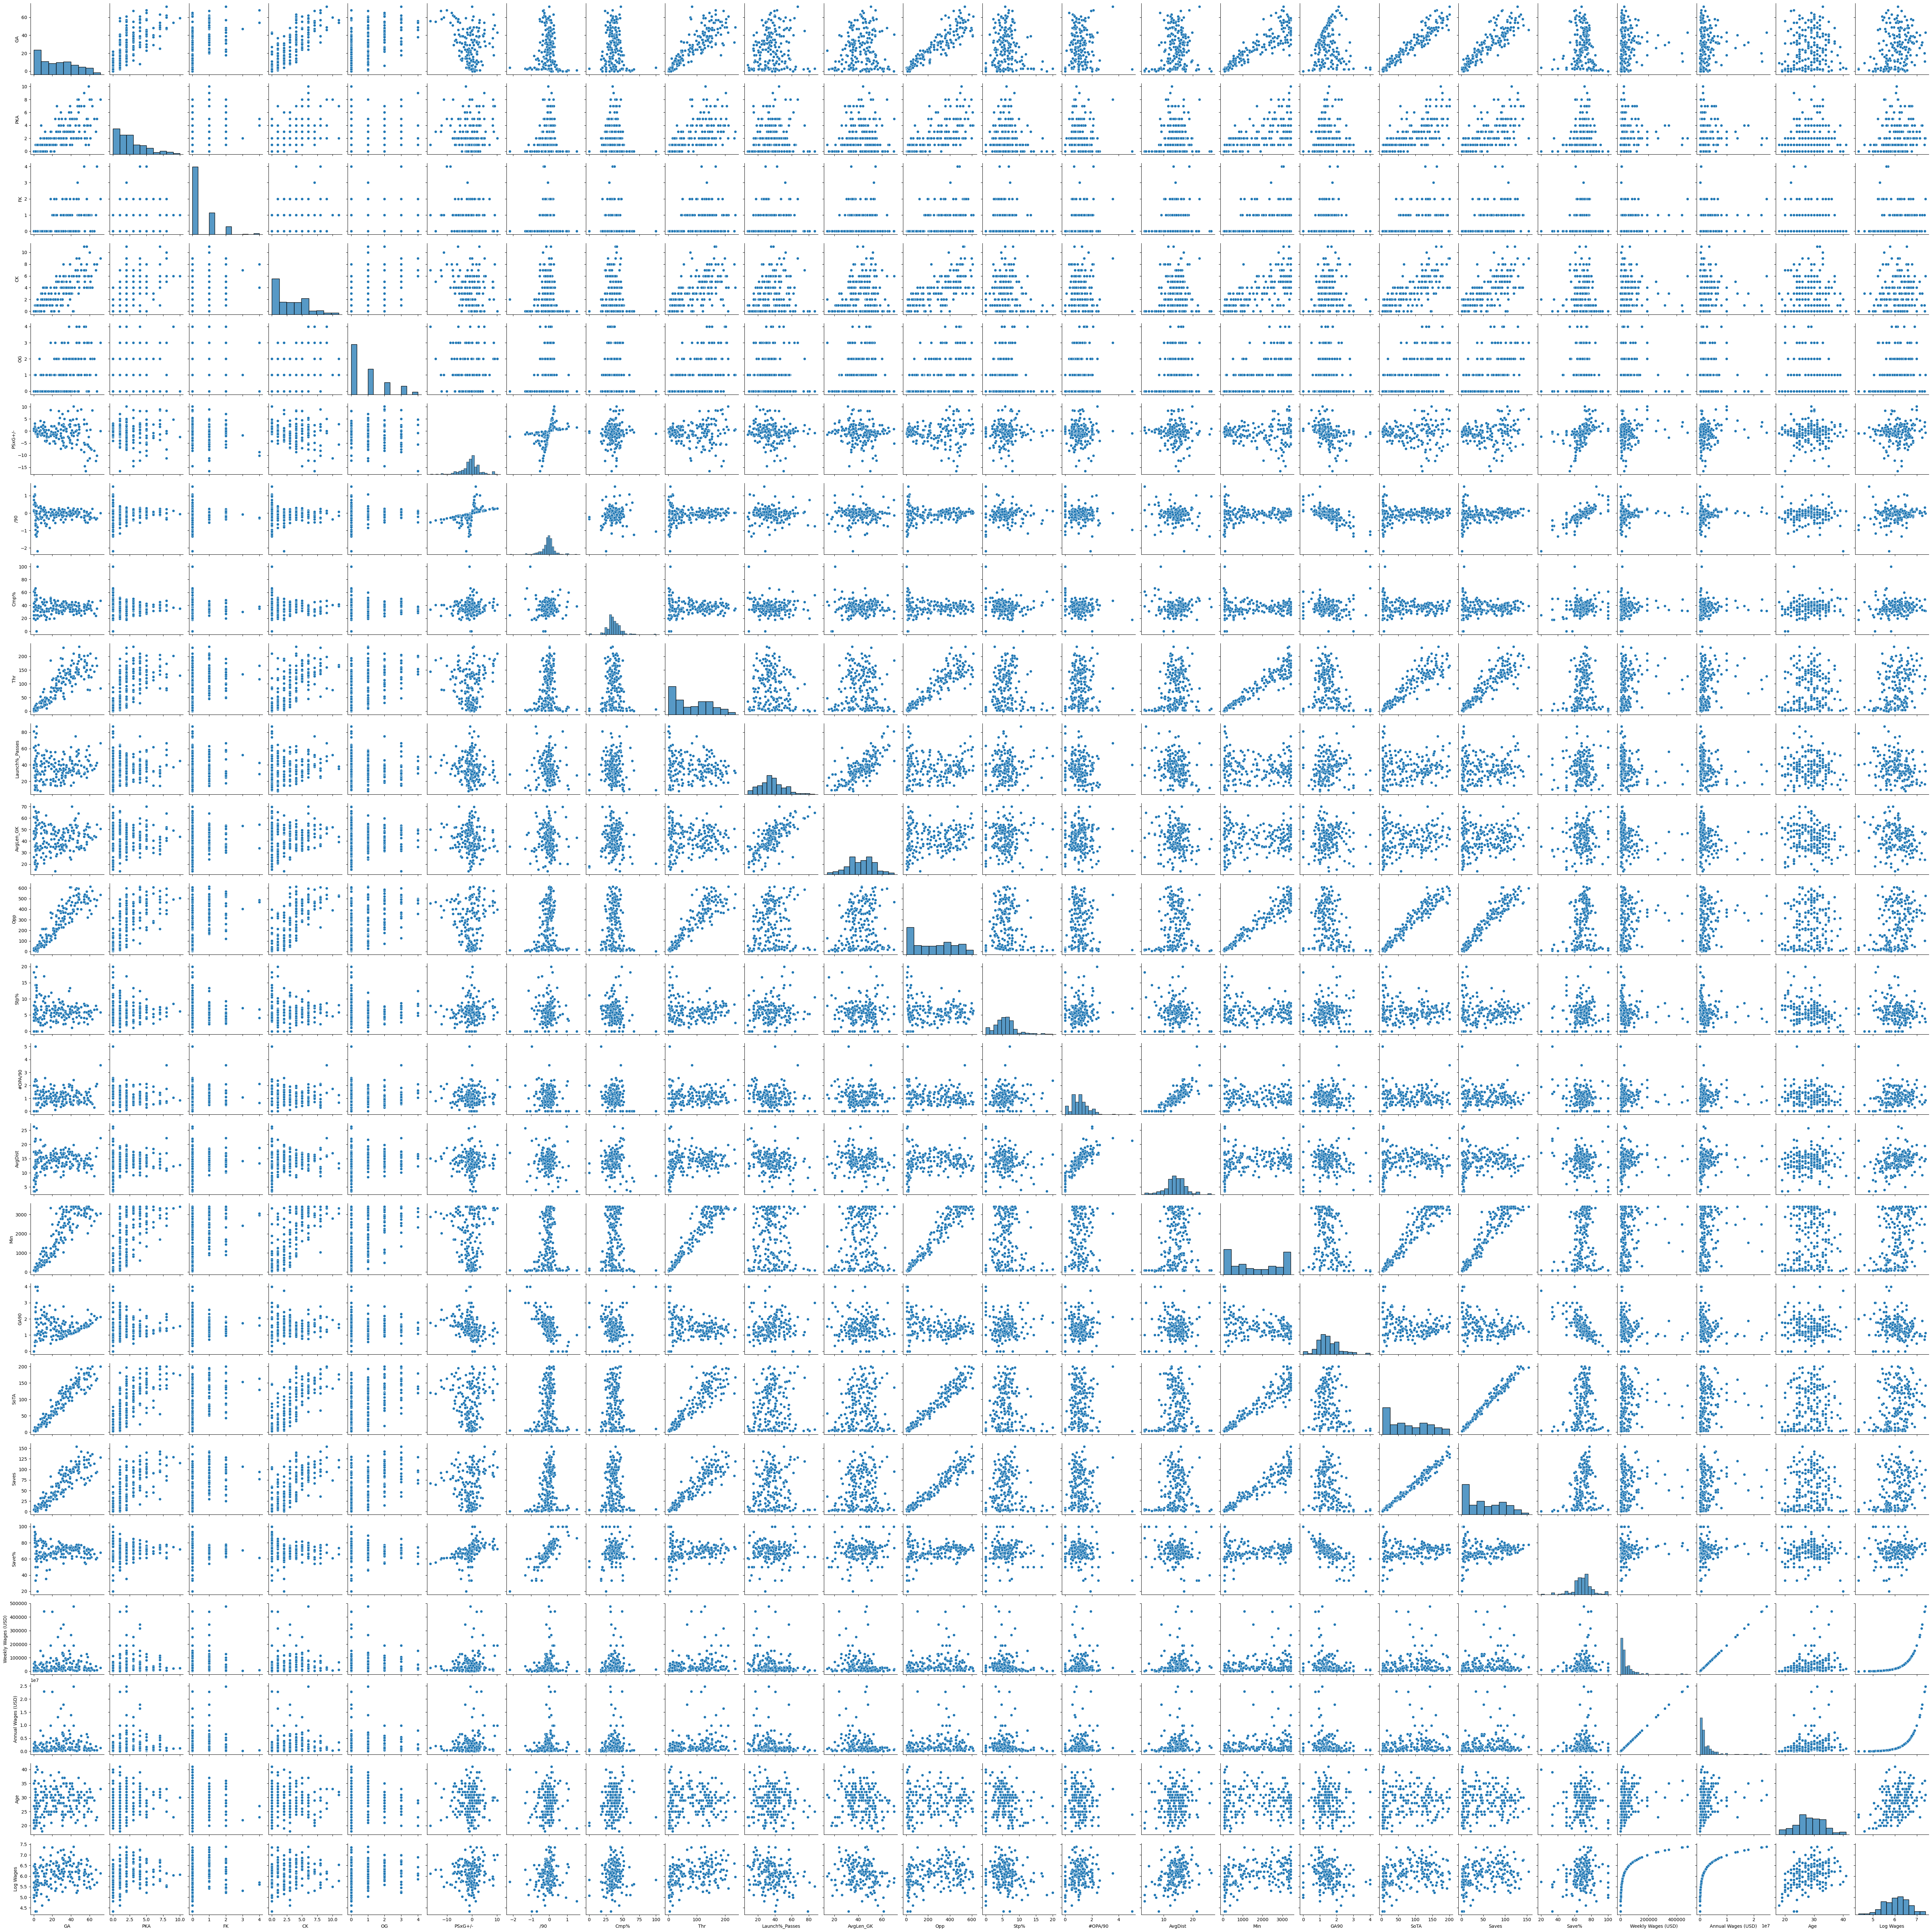

In [34]:
sns.pairplot(df2)

In [38]:
df2.describe().T

count          mean           std           min  \
GA                  197.0  2.556853e+01  1.929422e+01      0.000000   
PKA                 197.0  2.248731e+00  2.225561e+00      0.000000   
FK                  197.0  4.365482e-01  7.507033e-01      0.000000   
CK                  197.0  3.030457e+00  2.632041e+00      0.000000   
OG                  197.0  8.629442e-01  1.091010e+00      0.000000   
PSxG+/-             197.0 -7.502538e-01  3.937893e+00    -16.600000   
/90                 197.0 -7.893401e-02  3.967578e-01     -2.190000   
Cmp%                197.0  3.663604e+01  1.015780e+01      0.000000   
Thr                 197.0  8.350761e+01  6.438933e+01      0.000000   
Launch%_Passes      197.0  3.664670e+01  1.484143e+01      7.900000   
AvgLen_GK           197.0  4.217716e+01  1.092141e+01     13.900000   
Opp                 197.0  2.495279e+02  1.872794e+02      3.000000   
Stp%                197.0  5.923858e+00  3.365368e+00      0.000000   
#OPA/90             197.0  1.080457e+00  6.681686e-01      0.000000   
AvgDist             197.0  1.408426e+01  3.485364e+00      3.500000   
Min                 197.0  1.655472e+03  1.229927e+03     45.000000   
GA90                197.0  1.503706e+00  6.676902e-01      0.000000   
SoTA                197.0  7.871066e+01  5.949681e+01      3.000000   
Saves               197.0  5.355838e+01  4.162237e+01      1.000000   
Save%               197.0  6.902335e+01  1.169724e+01     20.000000   
Weekly Wages (USD)  197.0  4.875287e+04  7.327683e+04    421.000000   
Annual Wages (USD)  197.0  2.535149e+06  3.810394e+06  21869.000000   
Age                 197.0  2.848731e+01  4.767673e+00     18.000000   
Log Wages           197.0  6.078010e+00  5.604865e-01      4.339829   

                              25%           50%           75%           max  
GA                       8.000000  2.400000e+01  4.000000e+01  7.200000e+01  
PKA                      0.000000  2.000000e+00  3.000000e+00  1.000000e+01  
FK                       0.000000  0.000000e+00  1.000000e+00  4.000000e+00  
CK                       1.000000  3.000000e+00  5.000000e+00  1.100000e+01  
OG                       0.000000  0.000000e+00  1.000000e+00  4.000000e+00  
PSxG+/-                 -2.100000 -4.000000e-01  1.000000e+00  1.010000e+01  
/90                     -0.220000 -3.000000e-02  9.000000e-02  1.520000e+00  
Cmp%                    31.400000  3.590000e+01  4.110000e+01  1.000000e+02  
Thr                     21.000000  7.700000e+01  1.360000e+02  2.360000e+02  
Launch%_Passes          27.300000  3.530000e+01  4.480000e+01  8.700000e+01  
AvgLen_GK               34.900000  4.290000e+01  4.940000e+01  7.000000e+01  
Opp                     59.000000  2.220000e+02  4.040000e+02  6.140000e+02  
Stp%                     3.900000  5.800000e+00  7.400000e+00  2.000000e+01  
#OPA/90                  0.680000  1.000000e+00  1.420000e+00  5.000000e+00  
AvgDist                 12.200000  1.420000e+01  1.620000e+01  2.630000e+01  
Min                    408.000000  1.530000e+03  2.946000e+03  3.420000e+03  
GA90                     1.080000  1.420000e+00  1.880000e+00  4.000000e+00  
SoTA                    19.000000  7.200000e+01  1.320000e+02  2.000000e+02  
Saves                   13.000000  4.600000e+01  9.200000e+01  1.540000e+02  
Save%                   63.200000  6.950000e+01  7.490000e+01  1.000000e+02  
Weekly Wages (USD)    9463.000000  2.542000e+04  5.845800e+04  4.766280e+05  
Annual Wages (USD)  492057.000000  1.321847e+06  3.039820e+06  2.478464e+07  
Age                     25.000000  2.900000e+01  3.200000e+01  4.100000e+01  
Log Wages                5.692015  6.121181e+00  6.482848e+00  7.394183e+00